In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
class SpringSystem(torch.nn.Module):
    def __init__(self, positions, k=1.0, l0=1.0, frozens=[]) -> None:
        super().__init__()
        self.k = k
        self.l0=l0
        if len(frozens) == 0:
            frozens = torch.ones(size=(len(positions), 1))
        self.positions = torch.nn.ParameterList()
        for pos,frozen in zip(positions, frozens):
            self.positions.append(torch.nn.Parameter(torch.tensor(pos), requires_grad=bool(frozen)))
            
    def forward(self):
        energy = 0.0
        curr_pos = None
        for i, pos in enumerate(self.positions):
            if i == 0:
                curr_pos = pos
            else:
                dist = torch.linalg.norm(curr_pos - pos)
                curr_pos = pos
                energy+=1.0/2.0*self.k*(dist-self.l0)**2
        return energy
    
    def plot(self, ax, ms=30, color="C0", annotate_pos=-3e-2, fontsize=10):
        with torch.no_grad():
            positions = []
            for pos in self.positions:
                positions.append(pos.data.numpy())
            positions = np.array(positions)
            ax.plot(positions[:,0], positions[:,1], "o-", ms=ms, color=color, markeredgecolor="k", markeredgewidth=1.0)
            for i, pos in enumerate(positions):
                ax.annotate(f"{i+1}", (pos[0]+annotate_pos, pos[1]+annotate_pos), fontsize=fontsize, color="white")

def train(model, optimizer, N_steps):
    loss_vals = []
    for step in range(N_steps):
        optimizer.zero_grad()
        loss = model.forward()
        loss_vals.append(loss)
        loss.backward()
        optimizer.step()
    return loss_vals

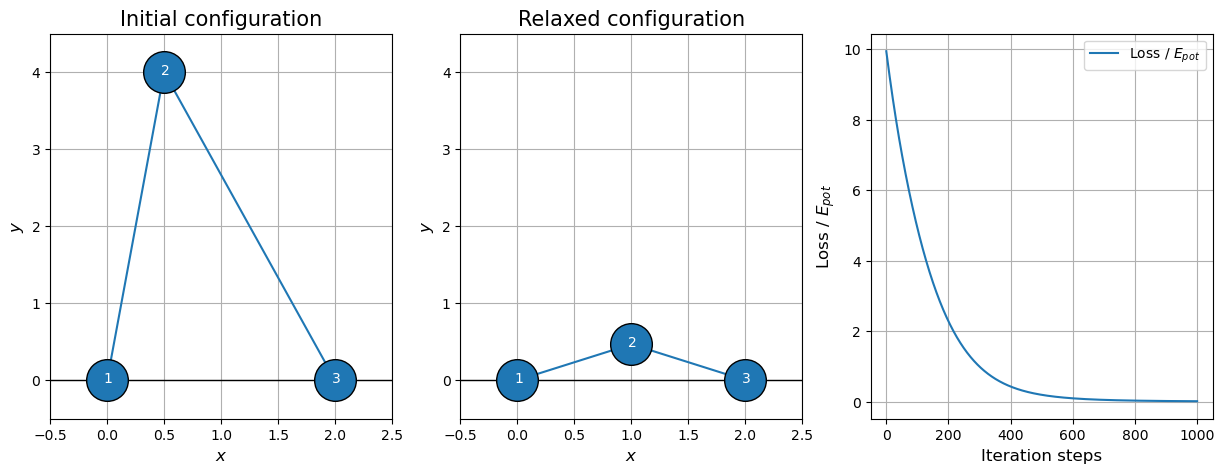

In [26]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
titles = ["Initial configuration", "Relaxed configuration"]
for ax, title in zip(axs[0:2], titles):
    ax.set_title(title, fontsize=15)
    ax.grid()
    ax.set_xlabel(r"$x$", fontsize=12)
    ax.set_ylabel(r"$y$", fontsize=12)
    ax.set_xlim([-0.5,2.5])
    ax.set_ylim([-0.5,4.5])
    ax.hlines(0.0, -5.0, 5.50, colors="k", lw=1)

axs[2].set_xlabel("Iteration steps", fontsize=12)
axs[2].set_ylabel(r"Loss / $E_{pot}$", fontsize=12)
axs[2].grid()
positions = np.array([[0.0,0.0],[0.5,4.0], [2.0,0.0]])
frozens = [False, True, False]
spring_sys = SpringSystem(positions=positions, frozens=frozens)
spring_sys.plot(ax=axs[0])

optimizer = torch.optim.Adam(spring_sys.parameters(), lr=0.01)
N_steps = 1000
loss_vals = train(model=spring_sys, optimizer=optimizer, N_steps=N_steps)
spring_sys.plot(ax=axs[1])
xs = np.linspace(0.0, len(loss_vals), len(loss_vals))
with torch.no_grad():
    axs[2].plot(xs, loss_vals, label=r"Loss / $E_{pot}$")
    axs[2].legend()

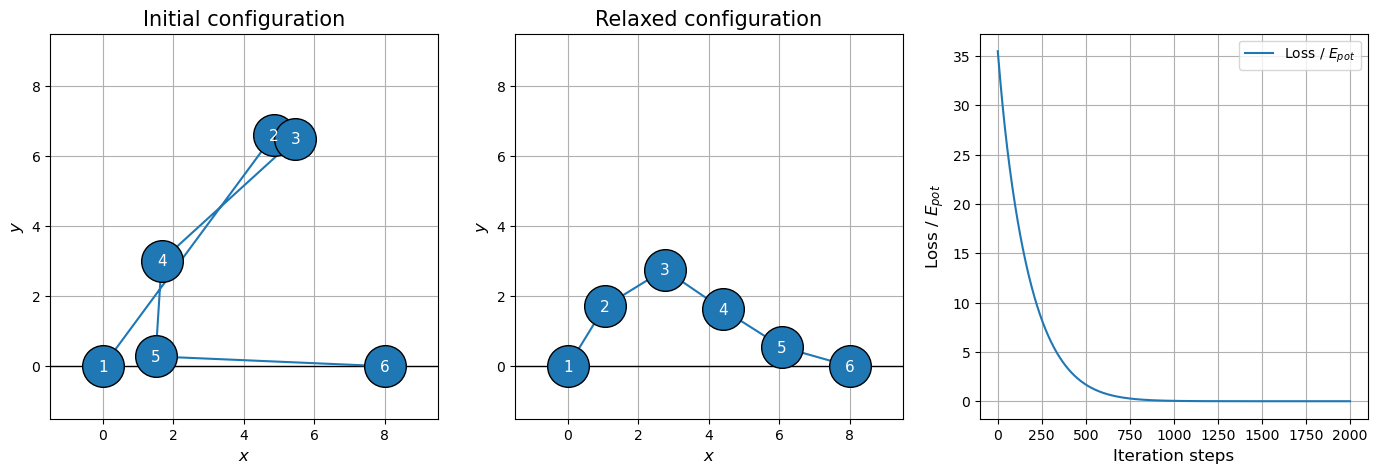

In [27]:
fig, axs = plt.subplots(1,3, figsize=(17,5))
titles = ["Initial configuration", "Relaxed configuration"]
for ax, title in zip(axs[0:2], titles):
    ax.set_title(title, fontsize=15)
    ax.grid()
    ax.set_xlabel(r"$x$", fontsize=12)
    ax.set_ylabel(r"$y$", fontsize=12)
    ax.set_xlim([-1.5,9.5])
    ax.set_ylim([-1.5,9.5])
    ax.hlines(0.0, -5.0, 10.50, colors="k", lw=1)


axs[2].set_xlabel("Iteration steps", fontsize=12)
axs[2].set_ylabel(r"Loss / $E_{pot}$", fontsize=12)
axs[2].grid()

r_rands = np.random.rand(4,2)*7.0
positions = np.concatenate((np.array([[0.0,0.0]]), r_rands, np.array([[8.0,0.0]])))
frozens = [False,True,True,True,True,False]
spring_sys = SpringSystem(positions=positions, frozens=frozens, l0=2.0)
spring_sys.plot(ax=axs[0], annotate_pos=-0.14, fontsize=11)

optimizer = torch.optim.Adam(spring_sys.parameters(), lr=0.01)
N_steps = 2000
loss_vals = train(model=spring_sys, optimizer=optimizer, N_steps=N_steps)
spring_sys.plot(ax=axs[1], annotate_pos=-0.14, fontsize=11)
xs = np.linspace(0.0, len(loss_vals), len(loss_vals))
with torch.no_grad():
    axs[2].plot(xs, loss_vals, label=r"Loss / $E_{pot}$")
    axs[2].legend()

In [23]:
class SpringSysGravity(SpringSystem):
    def __init__(self, positions, k=1, l0=1, mass=1.0, g=9.8, frozens=[]) -> None:
        super().__init__(positions, k, l0, frozens)
        self.g = g
        self.mass = mass
    
    def forward(self):
        E_grav = 0.0
        for pos in self.positions:
            E_grav+=self.mass*torch.dot(torch.tensor([0.0,1.0], dtype=torch.double), pos)
        E_spring = super().forward()
        return E_spring + E_grav
    
    def plot(self, ax, ms=30, color="C0", annotate_pos=-0.03, fontsize=10):
        return super().plot(ax, ms, color, annotate_pos, fontsize)

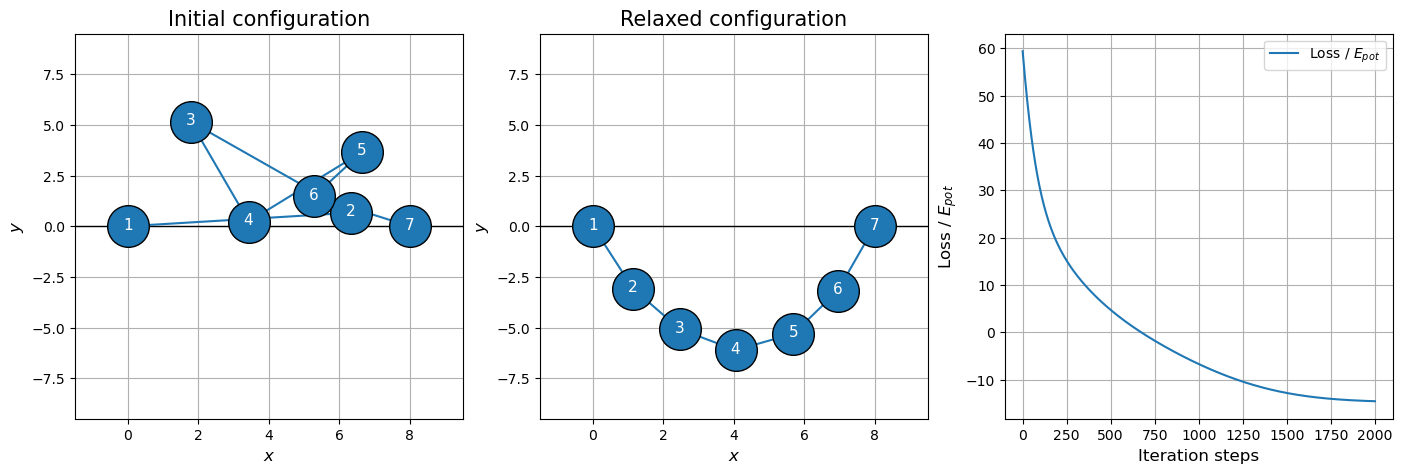

In [29]:
fig, axs = plt.subplots(1,3, figsize=(17,5))
titles = ["Initial configuration", "Relaxed configuration"]
for ax, title in zip(axs[0:2], titles):
    ax.set_title(title, fontsize=15)
    ax.grid()
    ax.set_xlabel(r"$x$", fontsize=12)
    ax.set_ylabel(r"$y$", fontsize=12)
    ax.set_xlim([-1.5,9.5])
    ax.set_ylim([-9.5,9.5])
    ax.hlines(0.0, -5.0, 10.50, colors="k", lw=1)

axs[2].set_xlabel("Iteration steps", fontsize=12)
axs[2].set_ylabel(r"Loss / $E_{pot}$", fontsize=12)
axs[2].grid()

r_rands = np.random.rand(5,2)*7.0
positions = np.concatenate((np.array([[0.0,0.0]]), r_rands, np.array([[8.0,0.0]])))
frozens = [False,True,True,True,True,True,False]
spring_sys = SpringSysGravity(positions=positions, frozens=frozens)
spring_sys.plot(ax=axs[0], annotate_pos=-0.14, fontsize=11)

optimizer = torch.optim.Adam(spring_sys.parameters(), lr=0.01)
N_steps = 2000
loss_vals = train(model=spring_sys, optimizer=optimizer, N_steps=N_steps)
spring_sys.plot(ax=axs[1], annotate_pos=-0.14, fontsize=11)
xs = np.linspace(0.0, len(loss_vals), len(loss_vals))
with torch.no_grad():
    axs[2].plot(xs, loss_vals, label=r"Loss / $E_{pot}$")
    axs[2].legend()